Problem Statement:  
This project develops a drowsiness detection system that classfies driver facial states (open/closed eyes, yawn/no yawn) using computer vision. The gaol is to detect drowsiness in real-time and trigger alerts to prevent road accidents caused by driver fatigue.

In [3]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_path='data'
classes=os.listdir(data_path)
print(f"Classes: {classes}")

Classes: ['.DS_Store', 'Closed', 'no_yawn', 'yawn', 'Open']


In [8]:
class_counts={}
for cls in classes:
    cls_path=os.path.join(data_path, cls)
    if os.path.isdir(cls_path):
        count=len(os.listdir(cls_path))
        class_counts[cls]=count
class_counts

{'Closed': 726, 'no_yawn': 725, 'yawn': 723, 'Open': 726}

In [10]:
df_meta=pd.DataFrame(list(class_counts.items()), columns=['Class','Count'])
df_meta

,Class,Count
0,Closed,726
1,no_yawn,725
2,yawn,723
3,Open,726


Text(0.5, 0, 'Class')

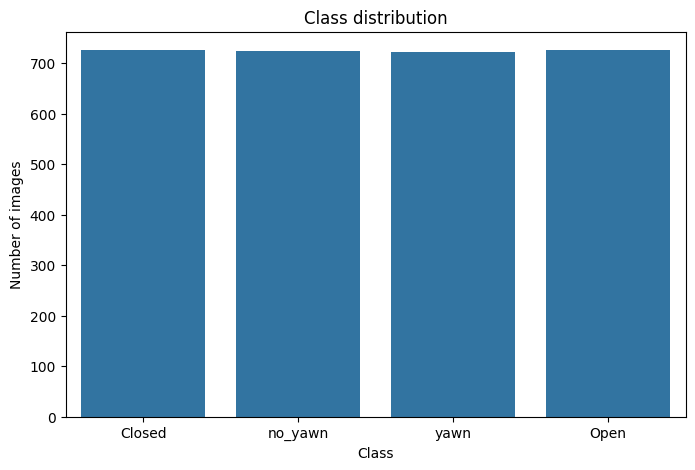

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_meta, x='Class', y='Count')
plt.title("Class distribution")
plt.ylabel("Number of images")
plt.xlabel("Class")

In [15]:
#Class imbalance check
print(f"Max: {df_meta['Count'].max()}")
print(f"Min: {df_meta['Count'].min()}")
print(f"Imbalance ratio: {df_meta['Count'].max()/df_meta['Count'].min():.2f}")

Max: 726
Min: 723
Imbalance ratio: 1.00


In [19]:
#sample images and extract properties
image_properties=[]

for cls in classes:
    cls_path=os.path.join(data_path,cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path)[:50]:
            img_path=os.path.join(cls_path, img_name)
            img=cv2.imread(img_path)
            if img is not None:
                h,w,c=img.shape
                image_properties.append({'class':cls, 'height':h, 'width':w, 'aspect_ratio': w/h, 'channels':c})
df_props=pd.DataFrame(image_properties)
df_props.describe()

,height,width,aspect_ratio,channels
count,200.000000,200.000000,200.000000,200.0
mean,419.560000,509.435000,1.204897,3.0
std,190.063667,226.624711,0.170528,0.0
min,54.000000,60.000000,0.879765,3.0
25%,300.000000,300.000000,1.000000,3.0
50%,480.000000,640.000000,1.333333,3.0
75%,480.000000,640.000000,1.333333,3.0
max,1166.000000,1269.000000,1.786667,3.0


Text(0.5, 1.0, 'Aspect ratio by class')

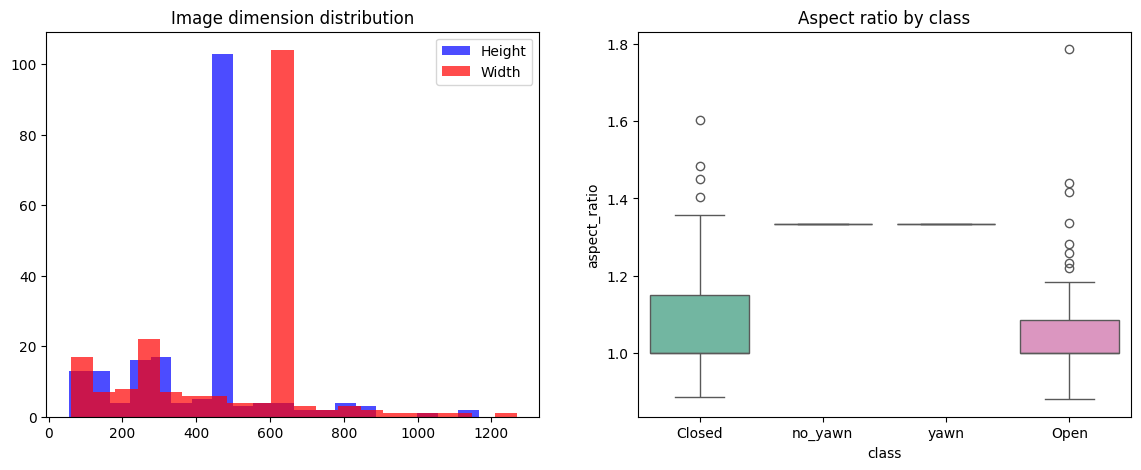

In [27]:
fig, axs= plt.subplots(1, 2, figsize=(14,5))

axs[0].hist(df_props['height'], bins=20, alpha=0.7, label="Height", color='blue')
axs[0].hist(df_props['width'], bins=20, alpha=0.7, label='Width', color='red')
axs[0].set_title('Image dimension distribution')
axs[0].legend()

sns.boxplot(data=df_props, x="class", y="aspect_ratio", ax=axs[1], palette='Set2')
axs[1].set_title('Aspect ratio by class')

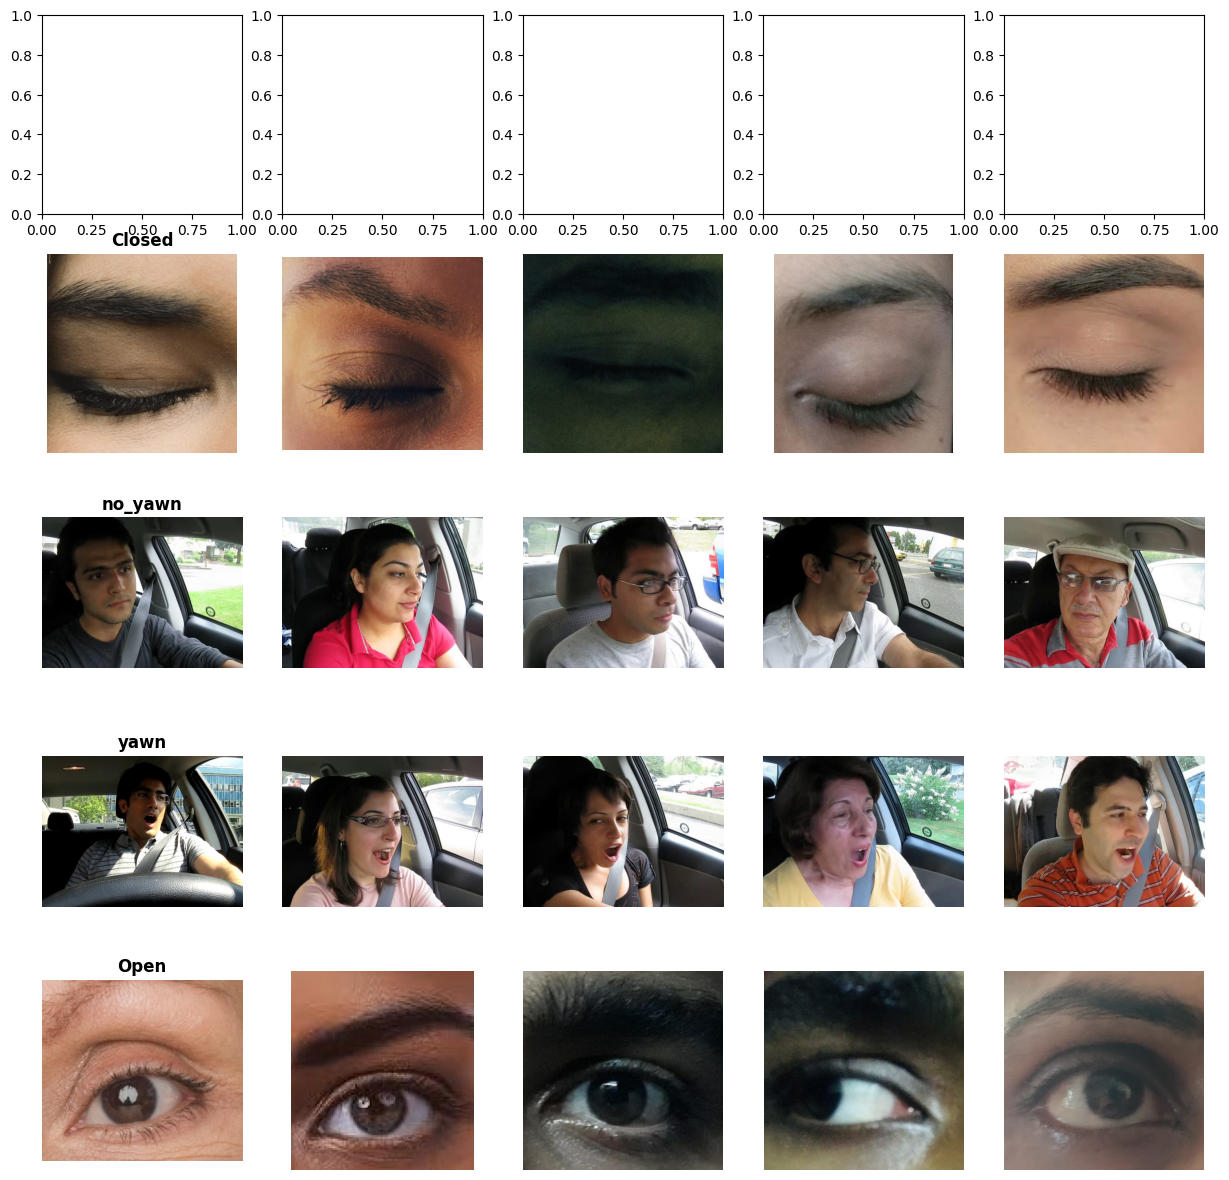

In [31]:
#displaying sample images from each class
fig, axs= plt.subplots(len(classes), 5, figsize=(15, 3*len(classes)))

for i, cls in enumerate(classes):
    cls_path=os.path.join(data_path, cls)
    if os.path.isdir(cls_path):
        images=os.listdir(cls_path)[:5]
        for j, img_name in enumerate(images):
            img_path=os.path.join(cls_path,img_name)
            img=cv2.imread(img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            if j==0:
                axs[i,j].set_title(f"{cls}", fontweight='bold')

Text(0.5, 1.0, 'RGB channel intensity by class')

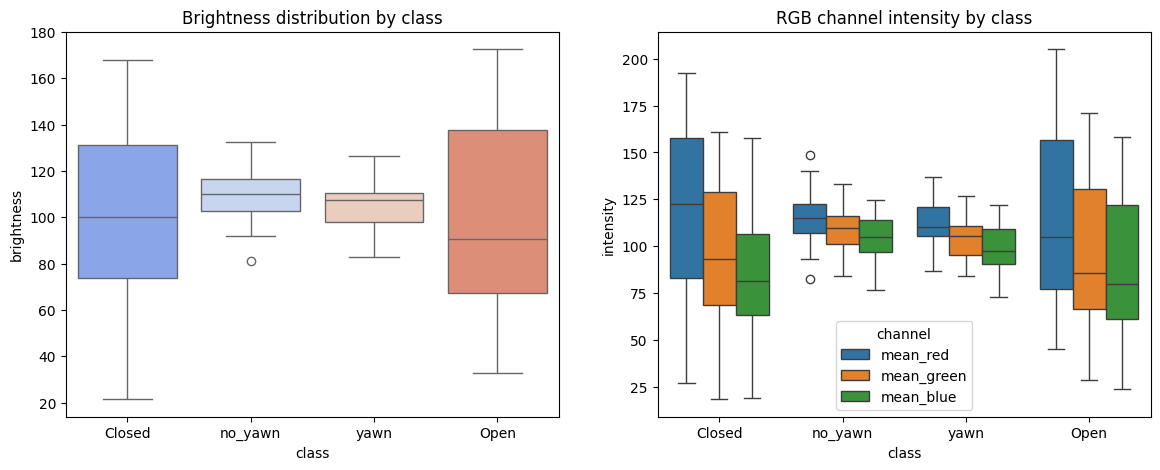

In [36]:
#Analysing color intensity distribution across classes
color_stats=[]

for cls in classes:
    cls_path=os.path.join(data_path, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path)[:30]:
            img_path=os.path.join(cls_path, img_name)
            img=cv2.imread(img_path)
            if img is not None:
                color_stats.append({'class':cls, 'mean_blue':img[:,:,0].mean(), 'mean_green':img[:,:,1].mean(), 'mean_red':img[:,:,2].mean(), 'brightness':img.mean()})
df_color=pd.DataFrame(color_stats)

fig,axs=plt.subplots(1,2,figsize=(14,5))
sns.boxplot(data=df_color, x='class', y='brightness', ax=axs[0], palette='coolwarm')
axs[0].set_title('Brightness distribution by class')

df_color_melted=df_color.melt(id_vars=['class'], value_vars=['mean_red','mean_green','mean_blue'], var_name='channel', value_name='intensity')
sns.boxplot(data=df_color_melted, x='class', y='intensity', hue='channel', ax=axs[1])
axs[1].set_title('RGB channel intensity by class')

Text(0, 0.5, 'Laplacian Variance')

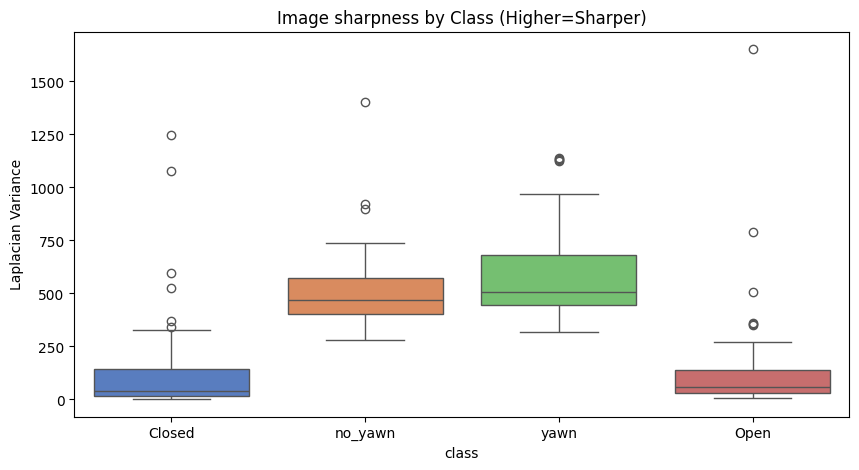

In [39]:
#checking for grainy/blurry images using laplacian variance
quality_scores=[]

for cls in classes:
    cls_path=os.path.join(data_path,cls)
    if os.path.isdir(cls_path):
        for image_name in os.listdir(cls_path)[:50]:
            img_path=os.path.join(cls_path, image_name)
            img=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                laplacian_var=cv2.Laplacian(img, cv2.CV_64F).var()
                quality_scores.append({'class':cls,'sharpness_score':laplacian_var})
df_quality=pd.DataFrame(quality_scores)

plt.figure(figsize=(10,5))
sns.boxplot(data=df_quality,x='class',y='sharpness_score', palette='muted')
plt.title('Image sharpness by Class (Higher=Sharper)')
plt.ylabel('Laplacian Variance')